# Очистка данных

In [36]:
from itertools import groupby

import findspark
from pyspark.sql.functions import isnan, when, count, col, isnull
import pyspark.sql.functions as F

## Считаем данные в формате parquet

In [3]:
import findspark
findspark.init()

Создадим SparkSession

In [4]:
from pyspark.sql import SparkSession

spark = (
    SparkSession
        .builder
        .appName("Data cleaning")
        .getOrCreate()
)


Загрузим неочищенные данные.

In [19]:
df_raw = spark.read.parquet("data_convert/data_raw.parquet")

In [20]:
df_raw.show(5)     # Show the data

+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|transaction_id|        tx_datetime|customer_id|terminal_id|tx_amount|tx_time_seconds|tx_time_days|tx_fraud|tx_fraud_scenario|
+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|    1755213645|2022-09-15 14:31:22|     476923|          0|    85.44|       96820282|        1120|       0|                0|
|    1755815962|2022-09-15 08:50:56|     860621|        617|      4.6|       96799856|        1120|       0|                0|
|    1755873140|2022-09-15 08:14:12|     897177|        194|    86.81|       96797652|        1120|       0|                0|
|    1756870334|2022-09-16 09:20:52|     534226|        604|    11.89|       96888052|        1121|       0|                0|
|    1755767002|2022-09-15 11:15:31|     829411|        213|    10.12|       96808531|        1120|       0|   

In [21]:
raw_count= df_raw.count()
print(raw_count)

46993904


In [23]:
df_raw.describe().show()

+-------+--------------------+------------------+------------------+------------------+------------------+-----------------+-------------------+-------------------+
|summary|      transaction_id|       customer_id|       terminal_id|         tx_amount|   tx_time_seconds|     tx_time_days|           tx_fraud|  tx_fraud_scenario|
+-------+--------------------+------------------+------------------+------------------+------------------+-----------------+-------------------+-------------------+
|  count|            46993904|          46993904|          46993491|          46993904|          46993904|         46993904|           46993904|           46993904|
|   mean|1.7622985251184585E9| 500451.4223348841|  26879.9722196208| 54.22865285548602|9.71999573775784E7|1124.499529811356|0.05413310628544502|0.10908421228421457|
| stddev|1.3565952932285953E7|288557.93352669955|1536397.0764264867|41.262622987753744| 748045.1067485658|8.655393634476038|0.22628016744490473|0.45806161067937196|
|    min| 

# Поиск незаполненных значений

In [44]:
df_raw.columns

['transaction_id',
 'tx_datetime',
 'customer_id',
 'terminal_id',
 'tx_amount',
 'tx_time_seconds',
 'tx_time_days',
 'tx_fraud',
 'tx_fraud_scenario']

In [10]:

df_raw.select([count(when(isnull(c), c)).alias(c) for c in df_raw.columns]).show()

+--------------+-----------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|transaction_id|tx_datetime|customer_id|terminal_id|tx_amount|tx_time_seconds|tx_time_days|tx_fraud|tx_fraud_scenario|
+--------------+-----------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|             0|         96|          0|        413|        0|              0|           0|       0|                0|
+--------------+-----------+-----------+-----------+---------+---------------+------------+--------+-----------------+



Видим, что колонки tx_datetime, terminal_id содержат null значения.
Удалим такие данные - не будем обрабатывать их.

In [24]:
df = df_raw.na.drop()

In [25]:
count_notnull = df.count()
print(count_notnull)

46993395


In [64]:
raw_count-count_notnull

509

# Дубликаты

In [28]:
distinct_count = df.distinct().count()
print(distinct_count)

In [30]:
count_notnull-distinct_count

62

# Распределение данных по колонкам

## tx_fraud_scenario

In [32]:
(df.groupBy('tx_fraud_scenario')  # Group by 'customer_id'
   .count()                 # Count the number of rows per group
   .sort('count', ascending=False)  # Sort by the count in descending order
   .show())                 # Show the result

+-----------------+--------+
|tx_fraud_scenario|   count|
+-----------------+--------+
|                0|44449445|
|                2| 2453878|
|                3|   64225|
|                1|   25785|
+-----------------+--------+



Каких-то аномалий не видно

## customer_id
Top-N кастомеров по количеству транзакций

In [47]:
(df.groupBy('customer_id')  # Group by 'customer_id'
   .count()                 # Count the number of rows per group
   .sort('count', ascending=False)  # Sort by the count in descending order
   .show(10))

+-----------+-----+
|customer_id|count|
+-----------+-----+
|      22459|  121|
|     649472|  120|
|     661757|  120|
|     722713|  119|
|     382529|  118|
|     692219|  117|
|     618973|  117|
|     652559|  117|
|     485437|  117|
|     827997|  117|
+-----------+-----+
only showing top 10 rows



Построим график

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

customers_count_by_transactions_count_df = ((df.groupBy('customer_id')
   .count()
   .withColumnRenamed("count", "transactions_count"))
.groupBy('transactions_count')
.count()
 .withColumnRenamed("count", "customers_count")
 .sort('transactions_count', ascending=False))

In [59]:
customers_count_by_transactions_count_df.show(5)

+------------------+---------------+
|transactions_count|customers_count|
+------------------+---------------+
|               121|              1|
|               120|              2|
|               119|              1|
|               118|              1|
|               117|             10|
+------------------+---------------+
only showing top 5 rows



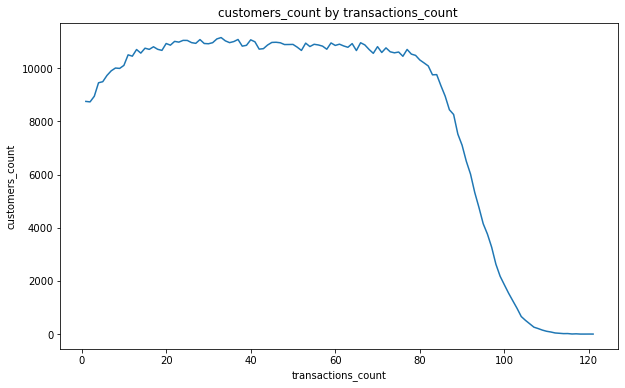

In [57]:

pd = customers_count_by_transactions_count_df.toPandas()

plt.figure(figsize=(10, 6))
sns.lineplot(x='transactions_count', y='customers_count', data=pd)
plt.xlabel('transactions_count')
plt.ylabel('customers_count')
plt.title('customers_count by transactions_count ')
plt.show()

Посмотрим на данные с customer_id=0. Возможно, их стоит отфильтровывать:

In [60]:
df.filter(df.customer_id==0).show(5)

+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|transaction_id|        tx_datetime|customer_id|terminal_id|tx_amount|tx_time_seconds|tx_time_days|tx_fraud|tx_fraud_scenario|
+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|    1782663048|2022-10-03 06:39:17|          0|        711|    54.41|       98347157|        1138|       0|                0|
|    1781096745|2022-10-02 17:27:30|          0|        711|    39.41|       98299650|        1137|       0|                0|
|    1774829369|2022-09-28 12:17:44|          0|         53|    47.19|       97935464|        1133|       0|                0|
|    1777963092|2022-09-30 21:22:00|          0|        934|    42.61|       98140920|        1135|       0|                0|
|    1770132988|2022-09-25 19:24:38|          0|        832|    52.14|       97701878|        1130|       0|   

## terminal_id

In [61]:
df.filter(df.terminal_id==0).show(5)

+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|transaction_id|        tx_datetime|customer_id|terminal_id|tx_amount|tx_time_seconds|tx_time_days|tx_fraud|tx_fraud_scenario|
+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|    1776393649|2022-09-28 09:43:05|     998575|          0|     89.0|       97926185|        1133|       0|                0|
|    1776602453|2022-09-29 17:18:03|     132032|          0|    32.09|       98039883|        1134|       0|                0|
|    1777310517|2022-09-29 06:35:11|     584255|          0|   171.34|       98001311|        1134|       0|                0|
|    1776046730|2022-09-28 13:19:33|     776986|          0|    42.29|       97939173|        1133|       0|                0|
|    1776595268|2022-09-29 07:13:32|     127511|          0|    36.08|       98003612|        1134|       0|   

# tx_amount

Нулевая сумма транзакции выглядит подозрительно. Посмотрим на данные

In [62]:
df.filter(df.tx_amount==0).show(5)

+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|transaction_id|        tx_datetime|customer_id|terminal_id|tx_amount|tx_time_seconds|tx_time_days|tx_fraud|tx_fraud_scenario|
+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|    1771462436|2022-09-25 04:03:27|     849633|        568|      0.0|       97646607|        1130|       0|                0|
|    1773322386|2022-09-27 11:34:42|      38327|        346|      0.0|       97846482|        1132|       0|                0|
|    1754786235|2022-09-15 14:56:25|     204274|         81|      0.0|       96821785|        1120|       0|                0|
|    1749985329|2022-09-12 10:06:28|     140179|        266|      0.0|       96545188|        1117|       0|                0|
|    1740540516|2022-09-06 17:55:56|     111157|        394|      0.0|       96054956|        1111|       0|   

Оценим количество

In [63]:
df.filter(df.tx_amount==0).count()

872

# Вывод

При загрузке данных наложим следующие ограничения
1) данные с null значениями не загружать (509 строк)
2) данные с нулевой суммой транзакции не загружать (872 строки)
3) дубликаты строк не загружать (62 строки)

Новая схема данных для загрузки из текстового формата:

In [65]:
from pyspark.sql.types import StructType, StructField, LongType, TimestampType, IntegerType, DoubleType

schema_not_null = StructType([
    StructField("transaction_id", LongType(), False),
    StructField("tx_datetime", TimestampType(), False),
    StructField("customer_id", IntegerType(), False),
    StructField("terminal_id", IntegerType(), False),
    StructField("tx_amount", DoubleType(), False),
    StructField("tx_time_seconds", LongType(), False),
    StructField("tx_time_days", IntegerType(), False),
    StructField("tx_fraud", IntegerType(), False),
    StructField("tx_fraud_scenario", IntegerType(), False)
])

Очистка датасета:

In [ ]:
df_clean=df_raw.distinct().filter(df.tx_amount>0)